In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pathlib
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold
%matplotlib inline
import matplotlib.pyplot as plt
from plotnine import *

## Functions

In [2]:
def make_data_imbens(df):
    df_new=df.drop(['nodegree'], axis=1)
    df_new['pos74']=(df_new['RE74']>0).astype(int)
    df_new['pos75']=(df_new['RE75']>0).astype(int)
    return df_new
    

In [3]:
def predict_g(X, y, do_kfold):
    predictions=np.full_like(y, np.nan, dtype=float)
    if do_kfold:        
        kf=KFold(n_splits=3, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(X):
            clf=RandomForestClassifier(random_state=42, oob_score=False, n_estimators=10, max_depth=3, class_weight='balanced')
            clf.fit(X[train_index],y[train_index])
            predictions[test_index]=clf.predict_proba(X[test_index])[:,1]
    #print('oob_score: '+ str(clf.oob_score_))
    else:
        clf=RandomForestClassifier(random_state=42, oob_score=False, n_estimators=10, max_depth=3, class_weight='balanced')
        clf.fit(X,y)
        predictions=clf.predict_proba(X)[:,1]
    assert np.isnan(predictions).sum()==0
    return predictions
    

In [4]:
def predict_Q(X,y,do_kfold):
    predictions=np.full_like(y, np.nan, dtype=float)
    if do_kfold:
        kf=KFold(n_splits=3, shuffle=True, random_state=42)
        for train_index, test_index in kf.split(X):
            reg=RandomForestRegressor(random_state=42, n_estimators=10, max_depth=3)
            reg.fit(X[train_index], y[train_index])
            predictions[test_index]=reg.predict(X[test_index])
    else:
        reg=RandomForestRegressor(random_state=42, n_estimators=10, max_depth=3)
        reg.fit(X, y)
        predictions=reg.predict(X)
    assert np.isnan(predictions).sum()==0
    return predictions

In [5]:
def calc_delta(alpha, g, bias):
    alpha_term=(1/alpha)-1
    bias_term=sp.special.digamma(g*alpha_term+1)\
        -sp.special.digamma((1-g)*alpha_term)\
        -sp.special.digamma(g*alpha_term)\
        +sp.special.digamma((1-g)*alpha_term+1)
    delta=bias/np.mean(bias_term)
    return delta

In [6]:
def calc_beta_shapes(g, alpha):
    alpha_shape=g*((1/alpha)-1)
    beta_shape=(1-g)*((1/alpha)-1)
    #print(alpha_shape, beta_shape)
    return alpha_shape, beta_shape
    

def calc_Rsq(alpha, delta, calculated_params, treatment, response):
    alpha_shape, beta_shape=calc_beta_shapes(calculated_params['g'], alpha)
    Rsq_num=delta**2*np.mean(sp.special.polygamma(1, alpha_shape+treatment)\
                             +sp.special.polygamma(1, beta_shape+(1-treatment)))
    Rsq_den=mean_squared_error(response, calculated_params['Q'])
    #print(Rsq_num, Rsq_den)
    return Rsq_num/Rsq_den
    
    

In [7]:
def calc_Rsq_hat(covariate_col, response_col, df, Q, do_kfold):
    y=df[response_col].values
    Qhat=predict_Q(df.drop([response_col]+covariate_col, axis=1).values, y, do_kfold)
    Rsqhat=(mean_squared_error(y, Qhat)-mean_squared_error(y, Q))/(mean_squared_error(y, Qhat))
    return Rsqhat

In [8]:
def calc_alpha_hat(covariate_col, response_col, treatment_col, df, g, do_kfold):
    #call y t
    t=df[treatment_col].values
    ghat=predict_g(df.drop([response_col, treatment_col]+covariate_col, axis=1).values, t, do_kfold)
#     ahat_numerator=np.var(g)-np.var(ghat)
#     ahat_denominator=np.mean(ghat*(1-ghat))
    ahat=1-(np.mean(g*(1-g))/np.mean(ghat*(1-ghat)))
    #ahat=ahat_numerator/ahat_denominator
    return ahat

In [71]:
def plot_sensitivity_graph(df, treatment_col, response_col, covariate_cols, covariate_groups, bias, do_kfold):
    #Calculate g and Q
    g=predict_g(df.drop([response_col, treatment_col], axis=1).values, df[treatment_col].values, do_kfold)
    Q=predict_Q(df.drop([response_col], axis=1).values, df[response_col].values, do_kfold)
    calculated_params=pd.DataFrame({'g': g, 'Q': Q})
    
    #Calculate alpha, delta, Rsq
    #alpha_series=pd.Series(np.arange(0.0001,1,0.0001))
    alpha_series=pd.Series(np.arange(0.001,1,0.001))
    delta_series=alpha_series.apply(calc_delta, g=calculated_params['g'], bias=bias)
    sensitivity_df=pd.DataFrame({'alphas':alpha_series, 'deltas':delta_series})
    Rsq=[]
    for n in range(len(alpha_series)):
        Rsq.append(calc_Rsq(alpha_series[n], delta_series[n], calculated_params, df[treatment_col], df[response_col]))
    sensitivity_df['Rsq']=Rsq
    
    #Plot observed co-variates
    alpha_hat=[]
    Rsq_hat=[]
    
    for covar in covariate_cols:
        alpha_hat.append(calc_alpha_hat(covar, response_col, treatment_col, df, calculated_params['g'], do_kfold))
        Rsq_hat.append(calc_Rsq_hat(covar, response_col, df, calculated_params['Q'], do_kfold))
    
    variable_importances=pd.DataFrame({'covariates':covariate_cols, 'alpha_hat': alpha_hat, 'Rsq_hat':Rsq_hat, 'groups':covariate_groups})
    
    print(variable_importances)
    
    variable_importances['labels']=variable_importances['covariates'].str[0]
    variable_importances.loc[(variable_importances['Rsq_hat']<0.05) & (variable_importances['alpha_hat']<0.2), 'labels']=''
    
    return (ggplot(data=sensitivity_df, mapping=aes(x='alphas', y='Rsq'))
            +geom_line(color='#585858', size=1)
            +theme_light()
            +geom_point(data=variable_importances, mapping=aes(x='alpha_hat', y='Rsq_hat', fill='groups'), color="black", alpha=0.6, size=2.5)
            +theme(figure_size=(3.5,3.5), legend_key = element_blank(), axis_title=element_text(size=10), axis_text=element_text(color='black'), plot_title=element_text(size=10))
            +scale_x_continuous(expand=[0, 0, 0, 0], limits=(-0.01,0.43))
            #+scale_y_continuous(expand=[0, 0, 0, 0], limits=(-0.02, min(0.75, max(Rsq+Rsq_hat))))
            +scale_y_continuous(expand=[0, 0, 0, 0], limits=(-0.02, 0.6))
            +labs(x=r'$\mathregular{\alpha}$', fill='', y='$R^2$', title='kfold= '+ str(do_kfold))
            +scale_fill_brewer(type='qual', palette='Set1')
            +geom_label(data=variable_importances, mapping=aes(x='alpha_hat', y='Rsq_hat', label='labels'), size=8, nudge_y=0.03)
            +annotate("text", x=0.35, y=0.06,label='Bias = $'+str(bias), size=8.5, color='#303030')
           )
    
    
    
    
    

In [2]:
print (plotnine.__version__)

NameError: name 'plotnine' is not defined

## Prepare data

In [10]:
col_names=['treatment', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 'RE74', 'RE75', 'RE78']

In [11]:
control=pd.read_csv(pathlib.Path.cwd().parents[0].joinpath('data', 'nswre74_control.txt'), header=None, sep=r"\s\s", names=col_names, engine='python')
treatment=pd.read_csv(pathlib.Path.cwd().parents[0].joinpath('data', 'nswre74_treated.txt'), header=None, sep=r"\s\s", names=col_names, engine='python')
psid=pd.read_csv(pathlib.Path.cwd().parents[0].joinpath('data', 'psid_controls.txt'), header=None, sep=r"\s\s", names=col_names, engine='python')

In [12]:
print(control.shape, treatment.shape, psid.shape)

(260, 10) (185, 10) (2490, 10)


In [13]:
imbens1=pd.concat([control,treatment]).reset_index(drop=True)
imbens1.head()

,treatment,age,education,black,hispanic,married,nodegree,RE74,RE75,RE78
0,0.0,23.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00
1,0.0,26.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12383.68
2,0.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00
3,0.0,18.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,10740.08
4,0.0,45.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,11796.47


In [14]:
imbens1=make_data_imbens(imbens1)
imbens1.head()

,treatment,age,education,black,hispanic,married,RE74,RE75,RE78,pos74,pos75
0,0.0,23.0,10.0,1.0,0.0,0.0,0.0,0.0,0.00,0,0
1,0.0,26.0,12.0,0.0,0.0,0.0,0.0,0.0,12383.68,0,0
2,0.0,22.0,9.0,1.0,0.0,0.0,0.0,0.0,0.00,0,0
3,0.0,18.0,9.0,1.0,0.0,0.0,0.0,0.0,10740.08,0,0
4,0.0,45.0,11.0,1.0,0.0,0.0,0.0,0.0,11796.47,0,0


In [15]:
imbens2=pd.concat([treatment, psid]).reset_index(drop=True)

In [16]:
imbens2=make_data_imbens(imbens2)
imbens2.head()

,treatment,age,education,black,hispanic,married,RE74,RE75,RE78,pos74,pos75
0,1.0,37.0,11.0,1.0,0.0,1.0,0.0,0.0,9930.0460,0,0
1,1.0,22.0,9.0,0.0,1.0,0.0,0.0,0.0,3595.8940,0,0
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.4500,0,0
3,1.0,27.0,11.0,1.0,0.0,0.0,0.0,0.0,7506.1460,0,0
4,1.0,33.0,8.0,1.0,0.0,0.0,0.0,0.0,289.7899,0,0


In [17]:
imbens3=pd.concat([treatment, psid]).reset_index(drop=True)
imbens3['change_earnings']=imbens3['RE78']-imbens3['RE74']
imbens3=make_data_imbens(imbens3)
imbens3=imbens3.drop('RE78', axis=1)
imbens3.head()

,treatment,age,education,black,hispanic,married,RE74,RE75,change_earnings,pos74,pos75
0,1.0,37.0,11.0,1.0,0.0,1.0,0.0,0.0,9930.0460,0,0
1,1.0,22.0,9.0,0.0,1.0,0.0,0.0,0.0,3595.8940,0,0
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.4500,0,0
3,1.0,27.0,11.0,1.0,0.0,0.0,0.0,0.0,7506.1460,0,0
4,1.0,33.0,8.0,1.0,0.0,0.0,0.0,0.0,289.7899,0,0


In [18]:
imbens4=pd.concat([treatment, psid]).reset_index(drop=True)
imbens4=imbens4[~((imbens4['RE74']>=5000) | (imbens4['RE75']>=5000))]
imbens4=imbens4.reset_index(drop=True)
#Does this match imbens' number of datapoints?
imbens4.groupby('treatment').count()
#yes!

,age,education,black,hispanic,married,nodegree,RE74,RE75,RE78
treatment,,,,,,,,,
0.0,242,242,242,242,242,242,242,242,242
1.0,148,148,148,148,148,148,148,148,148


In [19]:
imbens4=make_data_imbens(imbens4)
imbens4.head()

,treatment,age,education,black,hispanic,married,RE74,RE75,RE78,pos74,pos75
0,1.0,37.0,11.0,1.0,0.0,1.0,0.0,0.0,9930.0460,0,0
1,1.0,22.0,9.0,0.0,1.0,0.0,0.0,0.0,3595.8940,0,0
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.4500,0,0
3,1.0,27.0,11.0,1.0,0.0,0.0,0.0,0.0,7506.1460,0,0
4,1.0,33.0,8.0,1.0,0.0,0.0,0.0,0.0,289.7899,0,0


In [46]:
covariate_cols=['age', 'education', 'black', 'hispanic', 'married', 'RE75', 'pos74', 'pos75']
recent_earnings=['RE74', 'RE75']
#what about "pre-program earnings"? Is that RE74?
pre_program_earnings=['RE74']

covariates_for_graphs=[[x] for x in covariate_cols]
covariates_for_graphs.append(recent_earnings)
covariates_for_graphs.append(pre_program_earnings)

covariate_groups=['individual_covariates']*len(covariate_cols)+['recent_earnings', 'pre_program_earnings']


## Imbens1 results

     covariates  alpha_hat   Rsq_hat                groups
0         [age]   0.009190 -0.032642                   age
1   [education]   0.005096 -0.020045             education
2       [black]   0.001434 -0.011529                 black
3    [hispanic]   0.003582 -0.009316              hispanic
4     [married]  -0.002287 -0.013836               married
5        [RE75]   0.008251  0.002645                  RE75
6       [pos74]   0.002922 -0.002045                 pos74
7       [pos75]   0.004396 -0.005274                 pos75
8  [RE74, RE75]  -0.001743  0.016176       recent_earnings
9        [RE74]   0.001291 -0.010482  pre_program_earnings


C:\Users\light\Anaconda3\lib\site-packages\mizani\palettes.py:434: UserWarning: Warning message:Brewer palette Set1 has a maximum of 9 colorsReturning the palette you asked for withthat many colors
  warnings.warn(msg)
C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:74: UserWarning: geom_path: Removed 577 rows containing missing values.
  warn(msg.format(n1-n2))
C:\Users\light\Anaconda3\lib\site-packages\plotnine\layer.py:449: UserWarning: geom_point : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\light\Anaconda3\lib\site-packages\plotnine\layer.py:449: UserWarning: geom_label : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\light\Anaconda3\lib\site-packages\mizani\palettes.py:434: UserWarning: Warning message:Brewer palette Set1 has a maximum of 9 colorsReturning the palette you asked for withthat many colors
  warnings.warn(msg)


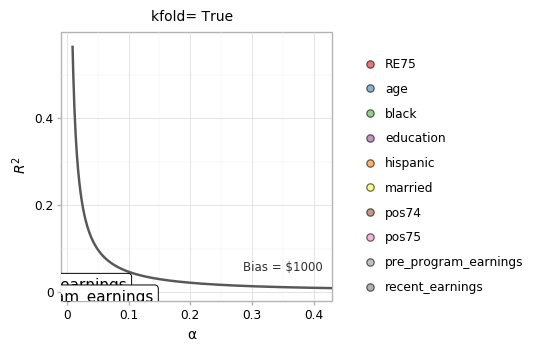

<ggplot: (147029745423)>

In [30]:
plot_sensitivity_graph(imbens1, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=True)

     covariates  alpha_hat   Rsq_hat                groups
0         [age]  -0.000111  0.007301                   age
1   [education]   0.003554  0.021058             education
2       [black]   0.001859  0.001030                 black
3    [hispanic]   0.004178 -0.002678              hispanic
4     [married]   0.006078 -0.000805               married
5        [RE75]   0.011156  0.023402                  RE75
6       [pos74]   0.006789  0.001314                 pos74
7       [pos75]   0.007476  0.001314                 pos75
8  [RE74, RE75]   0.004947  0.037792       recent_earnings
9        [RE74]   0.009500  0.009418  pre_program_earnings


C:\Users\light\Anaconda3\lib\site-packages\mizani\palettes.py:434: UserWarning: Warning message:Brewer palette Set1 has a maximum of 9 colorsReturning the palette you asked for withthat many colors
  warnings.warn(msg)
C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:74: UserWarning: geom_path: Removed 580 rows containing missing values.
  warn(msg.format(n1-n2))
C:\Users\light\Anaconda3\lib\site-packages\mizani\palettes.py:434: UserWarning: Warning message:Brewer palette Set1 has a maximum of 9 colorsReturning the palette you asked for withthat many colors
  warnings.warn(msg)


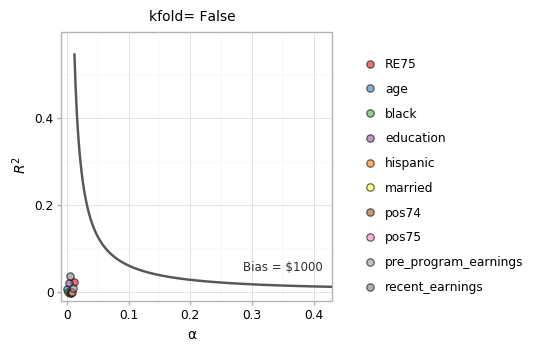

<ggplot: (-9223371889825205097)>

In [22]:
plot_sensitivity_graph(imbens1, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=False)

## Imbens2 results

     covariates  alpha_hat   Rsq_hat                 groups
0         [age]   0.049994 -0.000348  individual_covariates
1   [education]   0.093793  0.002167  individual_covariates
2       [black]   0.089747 -0.000026  individual_covariates
3    [hispanic]   0.073269  0.000000  individual_covariates
4     [married]   0.171808  0.000000  individual_covariates
5        [RE75]   0.239140  0.084090  individual_covariates
6       [pos74]   0.146788  0.000000  individual_covariates
7       [pos75]   0.063540  0.000000  individual_covariates
8  [RE74, RE75]   0.342459  0.357890        recent_earnings
9        [RE74]   0.197068  0.034693   pre_program_earnings


C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:74: UserWarning: geom_path: Removed 569 rows containing missing values.
  warn(msg.format(n1-n2))


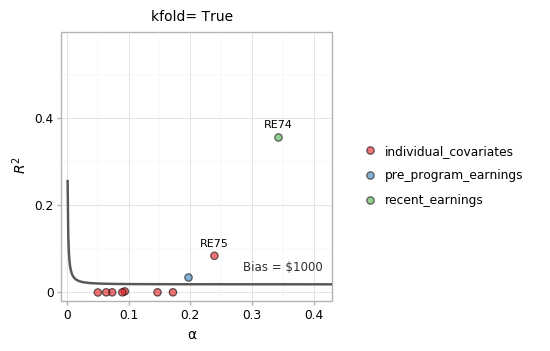

<ggplot: (-9223371889821218707)>

In [67]:
plot_sensitivity_graph(imbens2, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=True)

     covariates  alpha_hat       Rsq_hat                groups
0         [age]   0.023654 -1.465572e-16                   age
1   [education]   0.038416 -1.465572e-16             education
2       [black]   0.118367  0.000000e+00                 black
3    [hispanic]   0.051676 -1.465572e-16              hispanic
4     [married]   0.102664  0.000000e+00               married
5        [RE75]   0.222615  1.069351e-01                  RE75
6       [pos74]   0.122983 -1.465572e-16                 pos74
7       [pos75]   0.050472 -1.465572e-16                 pos75
8  [RE74, RE75]   0.268689  3.892966e-01       recent_earnings
9        [RE74]   0.182897  3.187298e-02  pre_program_earnings


C:\Users\light\Anaconda3\lib\site-packages\mizani\palettes.py:434: UserWarning: Warning message:Brewer palette Set1 has a maximum of 9 colorsReturning the palette you asked for withthat many colors
  warnings.warn(msg)
C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:74: UserWarning: geom_path: Removed 569 rows containing missing values.
  warn(msg.format(n1-n2))
C:\Users\light\Anaconda3\lib\site-packages\mizani\palettes.py:434: UserWarning: Warning message:Brewer palette Set1 has a maximum of 9 colorsReturning the palette you asked for withthat many colors
  warnings.warn(msg)


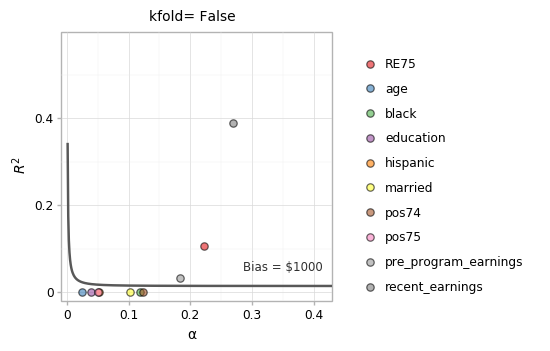

<ggplot: (147029683916)>

In [24]:
plot_sensitivity_graph(imbens2, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=False)

## Imbens 3 results

     covariates  alpha_hat   Rsq_hat                 groups
0         [age]   0.049994  0.000094  individual_covariates
1   [education]   0.093793  0.012082  individual_covariates
2       [black]   0.089747  0.006245  individual_covariates
3    [hispanic]   0.073269  0.005789  individual_covariates
4     [married]   0.171808  0.006218  individual_covariates
5        [RE75]   0.239140  0.041961  individual_covariates
6       [pos74]   0.146788  0.007062  individual_covariates
7       [pos75]   0.063540  0.009703  individual_covariates
8  [RE74, RE75]   0.342459  0.042609        recent_earnings
9        [RE74]   0.197068  0.053531   pre_program_earnings


C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:74: UserWarning: geom_path: Removed 569 rows containing missing values.
  warn(msg.format(n1-n2))


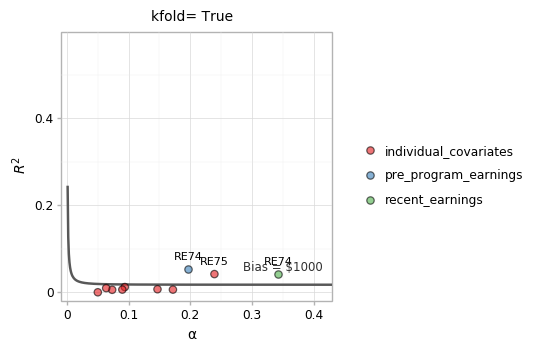

<ggplot: (-9223371889820991705)>

In [68]:
plot_sensitivity_graph(imbens3, treatment_col='treatment', response_col='change_earnings', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=True)

     covariates  alpha_hat       Rsq_hat                 groups
0         [age]   0.023654  1.331012e-03  individual_covariates
1   [education]   0.038416  5.140678e-03  individual_covariates
2       [black]   0.118367  2.417258e-05  individual_covariates
3    [hispanic]   0.051676  1.159721e-03  individual_covariates
4     [married]   0.102664  3.194241e-04  individual_covariates
5        [RE75]   0.222615  6.885221e-02  individual_covariates
6       [pos74]   0.122983  2.417258e-05  individual_covariates
7       [pos75]   0.050472  1.428739e-16  individual_covariates
8  [RE74, RE75]   0.268689  9.934257e-02        recent_earnings
9        [RE74]   0.182897  6.373313e-02   pre_program_earnings


C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:74: UserWarning: geom_path: Removed 569 rows containing missing values.
  warn(msg.format(n1-n2))


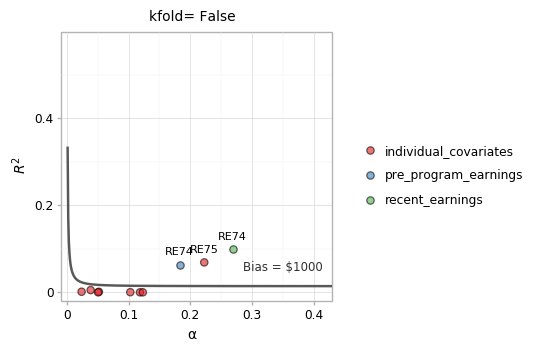

<ggplot: (-9223371889821002787)>

In [69]:
plot_sensitivity_graph(imbens3, treatment_col='treatment', response_col='change_earnings', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=False)

## Imbens4 results

     covariates  alpha_hat   Rsq_hat                 groups
0         [age]   0.205597  0.006522  individual_covariates
1   [education]   0.175836  0.058414  individual_covariates
2       [black]   0.235781  0.003151  individual_covariates
3    [hispanic]   0.019743  0.011947  individual_covariates
4     [married]   0.161594 -0.002795  individual_covariates
5        [RE75]  -0.036851  0.003848  individual_covariates
6       [pos74]  -0.009016 -0.001610  individual_covariates
7       [pos75]  -0.040660  0.001604  individual_covariates
8  [RE74, RE75]   0.040347 -0.011857        recent_earnings
9        [RE74]  -0.020837  0.003069   pre_program_earnings


C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:74: UserWarning: geom_path: Removed 571 rows containing missing values.
  warn(msg.format(n1-n2))
C:\Users\light\Anaconda3\lib\site-packages\plotnine\layer.py:449: UserWarning: geom_point : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
C:\Users\light\Anaconda3\lib\site-packages\plotnine\layer.py:449: UserWarning: geom_text : Removed 3 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


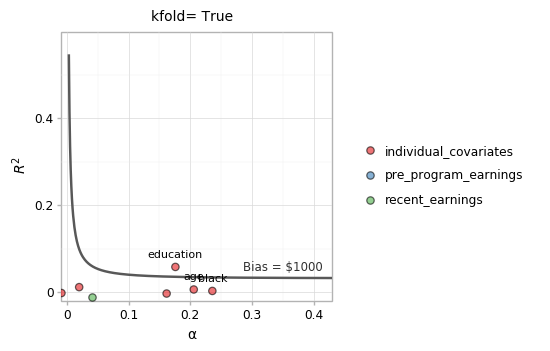

<ggplot: (147033753057)>

In [70]:
plot_sensitivity_graph(imbens4, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=True)

     covariates  alpha_hat   Rsq_hat                 groups
0         [age]   0.243647  0.094917  individual_covariates
1   [education]   0.210517  0.146431  individual_covariates
2       [black]   0.259567  0.000211  individual_covariates
3    [hispanic]   0.052713 -0.000157  individual_covariates
4     [married]   0.214431  0.003137  individual_covariates
5        [RE75]   0.000613  0.008552  individual_covariates
6       [pos74]   0.018241  0.002981  individual_covariates
7       [pos75]   0.006299 -0.000157  individual_covariates
8  [RE74, RE75]   0.114825  0.006138        recent_earnings
9        [RE74]   0.044227 -0.003283   pre_program_earnings


C:\Users\light\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:74: UserWarning: geom_path: Removed 572 rows containing missing values.
  warn(msg.format(n1-n2))


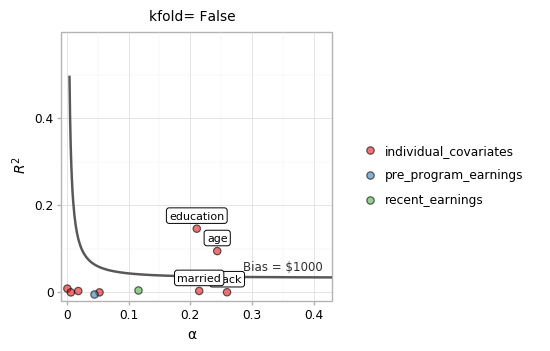

<ggplot: (147034950285)>

In [72]:
plot_sensitivity_graph(imbens4, treatment_col='treatment', response_col='RE78', covariate_cols=covariates_for_graphs, covariate_groups=covariate_groups, bias=1000, do_kfold=False)